# HW03: Embeddings

In [1]:
# Import Libraries
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim import models
from gensim import similarities

from sklearn.decomposition import PCA

## Simpsons Dataset

### Import training data

In [2]:
# Import data
simpsons_docs = []

# Open and read file
with open('./data/simpsons/X_train.csv', 'r') as read_obj:
    for row in csv.reader(read_obj):
        simpsons_docs.append(row)
        
# Glimpse at training docs
for i in range(0,10):
    print(simpsons_docs[i])

['lisa', 'i', 'will', 'do', 'the', 'dish', 'when', 'i', 'pick', 'it', 'out', 'of', 'the', 'chore', 'hat', 'and', 'it', 'is', 'not', 'a', 'practice', 'see', 'there', 'it', 'is', 'but', 'that', 'wa', 'a', 'practice', 'the', 'system', 'work']
['do', 'not', 'worry', 'i', 'have', 'got', 'a', 'man', 'on', 'the', 'perimeter']
['snowball']
['oh', 'yeah', 'you', 'were', 'way', 'off']
['oh', 'it', 'is', 'beautiful', 'oh', 'oh', 'let', 'u', 'put', 'bart', 's', 'beautiful', 'drawing', 'up', 'on', 'the', 'fridge']
['you', 're', 'halfway', 'home', 'lady']
['uh', 'hello']
['i', 'got', 'the', 'idea', 'from', 'the', 'regular', 'pen']
['you', 'cannot', 'teach', 'this', 'way']
['heh', 'heh', 'heh', 'moe', 'is', 'their', 'leader']


### Word2Vec Embeddings

In [3]:
# Define Word2Vec Embeddings
simpsons_w2v_model_150 = models.Word2Vec(simpsons_docs, size=150, window=2, min_count=10, sg=0, negative=10, workers=10)
simpsons_w2v_model_75 = models.Word2Vec(simpsons_docs, size=75, window=2, min_count=10, sg=0, negative=10, workers=10)
simpsons_w2v_model_15 = models.Word2Vec(simpsons_docs, size=15, window=2, min_count=10, sg=0, negative=10, workers=10)

# Train Word2Vec Embeddings
simpsons_w2v_model_150.train(simpsons_docs, total_examples=len(simpsons_docs), epochs=10)
simpsons_w2v_model_75.train(simpsons_docs, total_examples=len(simpsons_docs), epochs=10)
simpsons_w2v_model_15.train(simpsons_docs, total_examples=len(simpsons_docs), epochs=10)

(2888279, 4505780)

In [4]:
# Save W2V Embeddings
simpsons_w2v_model_150.save("./resources/embeddings/Simpsons_150_7.model")
simpsons_w2v_model_75.save("./resources/embeddings/Simpsons_75_7.model")
simpsons_w2v_model_15.save("./resources/embeddings/Simpsons_15_7.model")

In [5]:
len(simpsons_w2v_model_150.wv.vocab)

2754

### 2D Plots

In [6]:
def plot_similar_words(words, model, subplot_size = [2,2], xlim=[-5,5], ylim=[-5,5]):
    
    fig = plt.figure(figsize=(15, 12))
    fig.suptitle('Most similar words to:', fontsize=20)
    
    # Loop over the words
    for i, word in enumerate(words):
        
        # Retrieve similar words
        most_similar = model.wv.most_similar(positive=[word])

        similar_words = [word]
        for w in most_similar:
            similar_words.append(w[0])

        # Create PCA object with 2 components
        pca = PCA(n_components=2)

        # Extract embeddings from model
        vocab = list(model.wv.vocab)
        X = model.wv[vocab]

        # Fit PCA with all embeddings vocab
        pca.fit(X)

        # Transform similar words
        X_pca = pca.transform(model.wv[similar_words])

        # Plot
        df = pd.DataFrame(X_pca, index=similar_words, columns=['x', 'y'])
        
        plt.subplot(subplot_size[0], subplot_size[1], i+1)
        plt.title(str(word), fontsize=18)
        plt.grid(True)
        plt.xlim(xlim)
        plt.ylim(ylim)

        plt.scatter(df['x'], df['y'], s=100, c='b', alpha=0.25)
        plt.scatter(df['x'][0], df['y'][0], s=100, c='r', alpha=0.25)
        for word, pos in df.iterrows():
            plt.annotate(word, pos, fontsize=11)


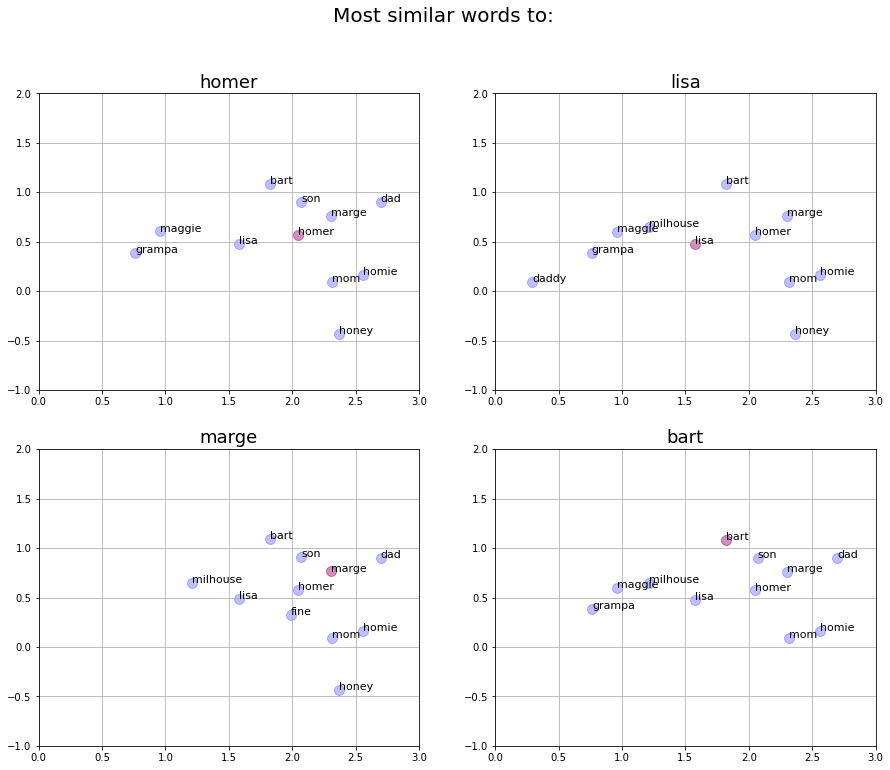

In [75]:
simpsons_characters = ['homer', 'lisa', 'marge', 'bart']
plot_similar_words(simpsons_characters, simpsons_w2v_model_15, subplot_size = [2,2], xlim=[-0,3], ylim=[-1,2])

### Relations

#### Similarity

How similar are two words?

In [8]:
def get_similarity_matrix(w2v_model, word_list):
    
    # Init matrix
    matrix = np.zeros((len(word_list),len(word_list)))
    
    # Get similarity between all words
    for i, wi in enumerate(word_list):
        for j, wj in enumerate(word_list):
            matrix[i][j] = w2v_model.wv.similarity(wi, wj)
            
    return matrix
        

In [9]:
# Get similarity matrix
word_list = ['homer', 'marge', 'bart', 'lisa', 'maggie', 'husband', 'wife', 'brother', 'sister', 'baby']
sim_matrix = get_similarity_matrix(simpsons_w2v_model_15, word_list)

<AxesSubplot:>

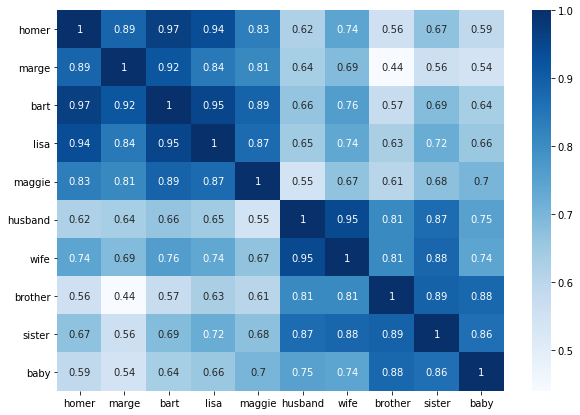

In [10]:
# Plot matrix
import seaborn as sn
sim_df = pd.DataFrame(sim_matrix, index = [i for i in word_list],columns = [i for i in word_list])
plt.figure(figsize = (10,7))
sn.heatmap(sim_df, annot=True, cmap='Blues')

#### Analogy

Which word is to $w_4$ as $w_1$ is to $w_2$?

In [11]:
simpsons_w2v_model_75.wv.most_similar(positive=["brother", "bart"], negative=['lisa'], topn=5)

[('sister', 0.6335598230361938),
 ('wife', 0.6156121492385864),
 ('ear', 0.6144956350326538),
 ('daughter', 0.6133790612220764),
 ('brain', 0.5903176069259644)]

In [69]:
simpsons_w2v_model_75.wv.most_similar(positive=["husband", "homer"], negative=['marge'], topn=5)

[('wife', 0.6264438033103943),
 ('brain', 0.5952317714691162),
 ('voice', 0.5908965468406677),
 ('behavior', 0.5872589945793152),
 ('soul', 0.580680251121521)]

In [13]:
simpsons_w2v_model_150.wv.most_similar(positive=["murder", "bob"], negative=['krusty'], topn=5)

[('nooo', 0.6121091246604919),
 ('accident', 0.542365550994873),
 ('eighty', 0.5354853272438049),
 ('generation', 0.5329500436782837),
 ('political', 0.5314483642578125)]

#### Doesn't Match

Which word doesn't match?

In [72]:
simpsons_w2v_model_150.wv.doesnt_match(['homer', 'lisa', 'krusty', 'bart', 'marge'])

'krusty'

In [67]:
simpsons_w2v_model_150.wv.doesnt_match(['nelson', 'bart', 'milhouse', 'skinner'])

'skinner'

In [16]:
simpsons_w2v_model_150.wv.doesnt_match(['carl', 'lenny', 'ralph'])

'ralph'

In [17]:
simpsons_w2v_model_150.wv.doesnt_match(['clancy', 'lou', 'eddie', 'bob'])

'bob'

## Friends Dataset

### Import Data

In [18]:
# Import data
friends_docs = []

# Open and read file
with open('./data/friends/X_train.csv', 'r') as read_obj:
    for row in csv.reader(read_obj):
        friends_docs.append(row)
        
# Glimpse at training docs
for i in range(0,5):
    print(friends_docs[i])

['okay', 'okay', 'i', 'll', 'tell', 'em', 'it', 'wasn', 't', 'chandler', 'who', 'got', 'high', 'now', 'who', 'should', 'i', 'say', 'it', 'wa']
['no']
['oh', 'you', 'do', 'not', 'want', 'me', 'on', 'the', 'trip']
['my', 'oh', 'my', 'god']
['nooo', 'but', 'it', 'but', 'it', 's', 'great']


### Word2Vec Embeddings

In [19]:
# Define Word2Vec Embeddings
friends_w2v_model_150 = models.Word2Vec(friends_docs, size=150, window=2, min_count=10, sg= 0, negative=10, workers=10)
friends_w2v_model_75 = models.Word2Vec(friends_docs, size=75, window=2, min_count=10, sg= 0, negative=10, workers=10)
friends_w2v_model_15 = models.Word2Vec(friends_docs, size=15, window=2, min_count=10, sg= 0, negative=10, workers=10)

# Train Word2Vec Embeddings
friends_w2v_model_150.train(friends_docs, total_examples=len(friends_docs), epochs=10)
friends_w2v_model_75.train(friends_docs, total_examples=len(friends_docs), epochs=10)
friends_w2v_model_15.train(friends_docs, total_examples=len(friends_docs), epochs=10)

(2569127, 4089210)

In [20]:
# Save W2V Embeddings
friends_w2v_model_150.save("./resources/embeddings/Friends_150_7.model")
friends_w2v_model_75.save("./resources/embeddings/Friends_75_7.model")
friends_w2v_model_15.save("./resources/embeddings/Friends_15_7.model")

In [21]:
len(friends_w2v_model_150.wv.vocab)

2017

### 2D Plots

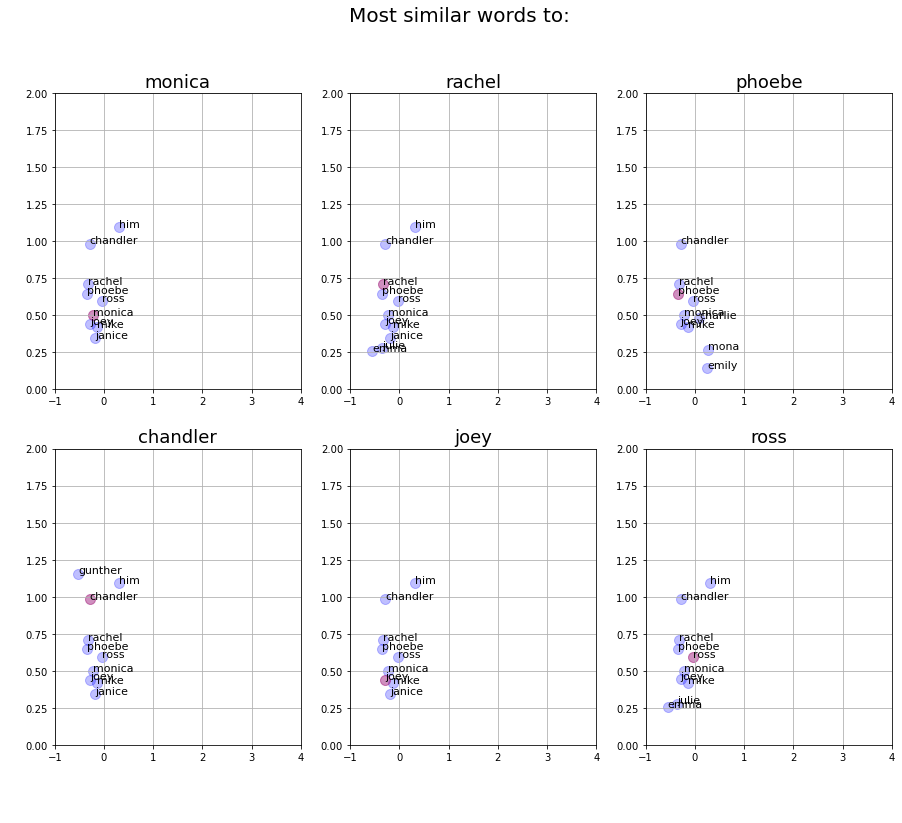

In [22]:
friends_characters = ['monica', 'rachel', 'phoebe', 'chandler', 'joey', 'ross']
plot_similar_words(friends_characters, friends_w2v_model_150, subplot_size = [2,3], xlim=[-1,4], ylim=[0,2])

### Relations

#### Similarity

How similar are two words?

In [56]:
# Get similarity matrix
word_list = ['chandler', 'joey', 'ross', 'monica', 'rachel', 'phoebe', 'coffee', 'central','husband', 'wife', 'friend']
sim_matrix = get_similarity_matrix(friends_w2v_model_150, word_list)

<AxesSubplot:>

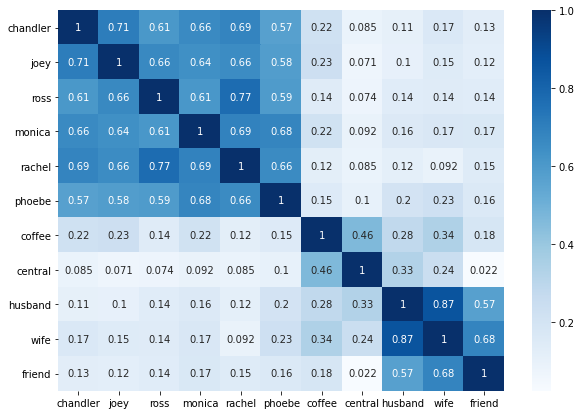

In [57]:
# Plot matrix
import seaborn as sn
sim_df = pd.DataFrame(sim_matrix, index = [i for i in word_list],columns = [i for i in word_list])
plt.figure(figsize = (10,7))
sn.heatmap(sim_df, annot=True, cmap='Blues')

#### Analogy

Which word is to $w_4$ as $w_1$ is to $w_2$?

In [34]:
friends_w2v_model_15.wv.most_similar(positive=["wife", "rachel"], negative=['husband'], topn=5)

[('ross', 0.8799484968185425),
 ('monica', 0.8615226745605469),
 ('joey', 0.8527945280075073),
 ('chandler', 0.8456325531005859),
 ('phoebe', 0.7731560468673706)]

In [38]:
friends_w2v_model_15.wv.most_similar(positive=["woman", "monica"], negative=['boy'], topn=5)

[('chandler', 0.788609504699707),
 ('rachel', 0.7634745836257935),
 ('ross', 0.7256302833557129),
 ('everyone', 0.6901733875274658),
 ('joey', 0.6817102432250977)]

#### Doesn't Match

Which word doesn't match?

In [71]:
friends_w2v_model_150.wv.doesnt_match(['chandler', 'joey', 'ross', 'monica', 'rachel', 'phoebe', 'janice'])

'janice'

In [28]:
friends_w2v_model_150.wv.doesnt_match(['chandler', 'joey', 'ross', 'monica', 'rachel', 'phoebe', 'gunther'])

'gunther'